<a href="https://colab.research.google.com/github/Mohit501/Automatic-Colorization-Encoder-on-CIFAR10/blob/main/Automatic_Colorization_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing required libraries 

In [1]:
from tensorflow import keras
from keras.layers import Dense,Input,Conv2D,Flatten,Reshape,Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

# Defining a function that converts colored images to grayscale

In [2]:
def rgb2gray(rgb):
  return np.dot(rgb[...,:3],[0.288,0.587,0.114])

## Loading CIFAR10 data

In [3]:
(x_train,_),(x_test,_) = cifar10.load_data()

## Input image dimensions

In [4]:
x_train.shape

(50000, 32, 32, 3)

In [5]:
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

## Creating saved images folder

In [6]:
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(),imgs_dir)
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)

# Displaying 1st 100 input images color and gray

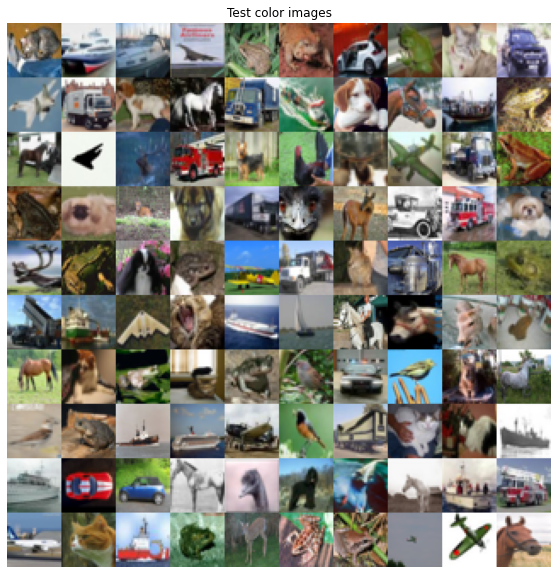

In [7]:
imgs = x_test[:100]
imgs = imgs.reshape((10,10,img_rows,img_cols,channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize = (25,10))
plt.axis('off')
plt.title('Test color images')
plt.imshow(imgs)
plt.savefig('%s/test_color.png' %imgs_dir)
plt.show()

Converting images to gray scale

In [8]:
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

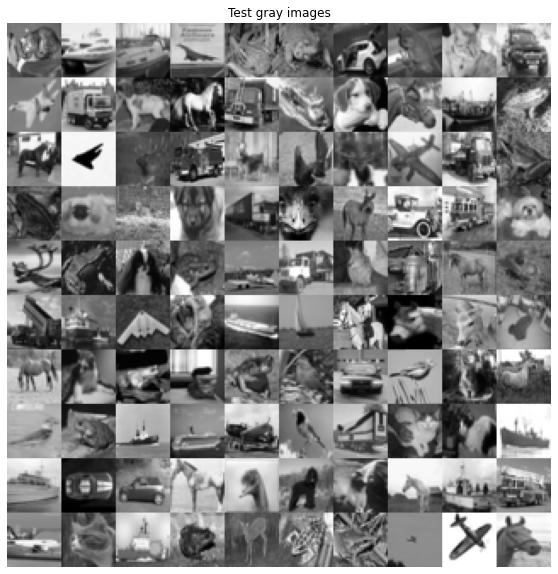

In [9]:
imgs = x_test_gray[:100]
imgs = imgs.reshape((10,10,img_rows,img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize = (25,10))
plt.axis('off')
plt.title('Test gray images')
plt.imshow(imgs,cmap='gray')
plt.savefig('%s/test_gray.png' %imgs_dir)
plt.show()

## Pre-Processing

In [10]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train_gray = x_train_gray.astype('float32')/255
x_test_gray = x_test_gray.astype('float32')/255

In [11]:
x_train = x_train.reshape(x_train.shape[0],img_rows,img_cols,channels)
x_test = x_test.reshape(x_test.shape[0],img_rows,img_cols,channels)
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0],img_rows,img_cols,1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0],img_rows,img_cols,1)

## AutoEncoder

In [12]:
input_shape = (img_rows,img_cols,1)
layer_filters = [64,128,256]

1.Encoder

In [13]:
inputs = Input(shape=input_shape)
x = inputs 
for filter in layer_filters:
  x = Conv2D(filters=filter,kernel_size = 2,strides = 2 , padding='same' , activation='relu')(x)

shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(256,name = 'latent_vector')(x)

encoder = Model(inputs,latent,name = 'encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         32896     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         131328    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,213,376
Trainable params: 1,213,376
Non-trainable params: 0
_________________________________________________

2.Decoder

In [14]:
latent_inputs = Input(shape = (256,),name = 'decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1],shape[2],shape[3]))(x)

for filter in layer_filters[::-1]:
  x = Conv2DTranspose(filters=filter,kernel_size = 2,strides=2,padding='same',activation = 'relu')(x)

outputs = Conv2DTranspose(filters=channels,kernel_size =2,activation='sigmoid',padding = 'same',name = 'decoder_output')(x)

decoder = Model(latent_inputs,outputs,name = 'decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              1052672   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         262400    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       131200    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 64)        32832     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)         771 

3.AutoEncoder

In [15]:
autoencoder = Model(inputs,decoder(encoder(inputs)),name = 'autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 256)               1213376   
_________________________________________________________________
decoder (Functional)         (None, 32, 32, 3)         1479875   
Total params: 2,693,251
Trainable params: 2,693,251
Non-trainable params: 0
_________________________________________________________________


**Model Saving Directory**


In [16]:
save_dir = os.path.join(os.getcwd(),'saved_models')
model_name = 'colored_ae'
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)
filepath = os.path.join(save_dir,model_name)

In [17]:
print(filepath)

/content/saved_models/colored_ae


**Reducing learning rates by sqrt(0.1) if loss doesnt improve in 5 epochs**

In [18]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),cooldown = 0,patience = 5,min_lr = 0)

**Save Weights for future use by creating checkpoints**

In [19]:
checkpoint = ModelCheckpoint(filepath=filepath,monitor = 'val_loss',save_best_only=True)

In [20]:
autoencoder.compile(loss = 'mse',optimizer='adam')


In [21]:
callbacks = [lr_reducer,checkpoint]

In [22]:
autoencoder.fit(x_train_gray,x_train,epochs=30,batch_size=32,callbacks=callbacks)

Epoch 1/30
1563/1563 [==============================] - 12s 6ms/step - loss: 0.0222
Epoch 2/30
1563/1563 [==============================] - 9s 5ms/step - loss: 0.0099
Epoch 3/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0086
Epoch 4/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0081
Epoch 5/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0075
Epoch 6/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0073
Epoch 7/30
1563/1563 [==============================] - 9s 5ms/step - loss: 0.0070
Epoch 8/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0068
Epoch 9/30
1563/1563 [==============================] - 9s 5ms/step - loss: 0.0066
Epoch 10/30
1563/1563 [==============================] - 9s 5ms/step - loss: 0.0065
Epoch 11/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0063
Epoch 12/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0061


In [23]:
x_decoded = autoencoder.predict(x_test_gray)

## Displaying Results

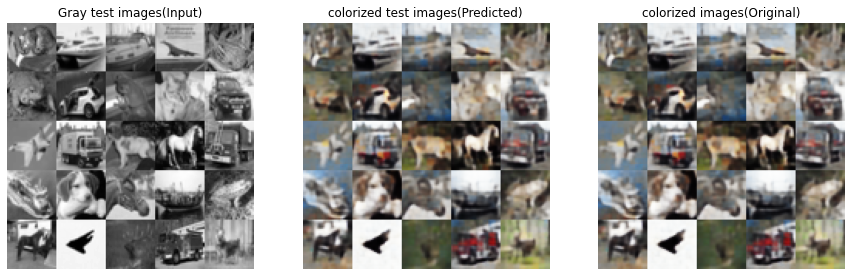

In [31]:
imgs = x_decoded[:25]
imgs = imgs.reshape((5,5,img_rows,img_cols,channels))
imgs = np.vstack([np.hstack(i) for i in imgs])

img = x_test_gray[:25]
img = img.reshape((5,5,img_rows,img_cols))
img = np.vstack([np.hstack(i) for i in img])


im = x_test[:25]
im = im.reshape((5,5,img_rows,img_cols,channels))
im = np.vstack([np.hstack(i) for i in im])


fig,ax = plt.subplots(1,3,figsize = (15,5))
ax[0].axis('off')
ax[0].imshow(img,cmap = 'gray')
ax[0].set_title('Gray test images(Input)')

ax[1].axis('off')
ax[1].imshow(imgs)
ax[1].set_title('colorized test images(Predicted)')


ax[2].axis('off')
ax[2].imshow(imgs)
ax[2].set_title('colorized images(Original)')

plt.show()